## YOLO11 모델 파인튜닝 과정  
1) v1. 랜덤 가중치 학습  
2) v2. 추가 학습  
3) v3. COCO 가중치(사전 학습된 데이터셋)사용하여 학습  
4) v4. 백본 동결 후 파인튜닝  

---  

- **학습 결과 비교**  

| Model       | Precision (P) | Recall (R) | mAP@50 | mAP@50-95 | Inference Speed (it/s) |
|-------------|---------------|------------|--------|-----------|-------------------------|
| YOLO11s_v1  | 0.661         | 0.623      | 0.684  | 0.418     | 13.95                  |
| YOLO11s_v2  | 0.657         | 0.653      | 0.701  | 0.424     | 3.42                   |
| YOLO11s_v3  | 0.688         | 0.660      | 0.711  | 0.436     | 3.54                   |
| **YOLO11s_v4**  | **0.729**     | **0.630**  | **0.706**| **0.442** | **4.44**               |  

---  

- **선택 모델 버전: v4. 백본 동결 후 파인튜닝 버전**
  - Precision과 mAP@50-95가 가장 높아, 다양한 객체 크기에서도 정확한 예측 가능하다고 판단함  

---  
- **사용 데이터셋**  
  - Roboflow 공개 데이터셋: Billboard Dataset
  - 총 이미지: 3,399장 (Train: 2,719 / Valid: 510 / Test: 170)

In [ ]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
# 테스트 이미지 다운로드
!gdown 1JZA7_aM-k5-0N0kvvFLPcRI3RvRXo9zN  # test02.jpg
!gdown 1VaDFbs3YPmwO5foQHbM4a32QMGDOYAZm  # test03.jpg
!gdown 1uHkOEIMeeopf3AfhoCPfriXhLKkPNJBM # test04
!gdown 1JLNgO8GYuTZoAyJFHprDd1JZqC25Sq8M # test05
!gdown 1LTBmPwSoy6FVjhAS8ILFvaC7zUC4dFaI # test06

Downloading...
From: https://drive.google.com/uc?id=1JZA7_aM-k5-0N0kvvFLPcRI3RvRXo9zN
To: /content/test02.jpg
100% 169k/169k [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VaDFbs3YPmwO5foQHbM4a32QMGDOYAZm
To: /content/test03.jpg
100% 34.2k/34.2k [00:00<00:00, 79.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uHkOEIMeeopf3AfhoCPfriXhLKkPNJBM
To: /content/test04.jpg
100% 318k/318k [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JLNgO8GYuTZoAyJFHprDd1JZqC25Sq8M
To: /content/test05.jpg
100% 805k/805k [00:00<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LTBmPwSoy6FVjhAS8ILFvaC7zUC4dFaI
To: /content/test06.jpg
100% 116k/116k [00:00<00:00, 132MB/s]


In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from roboflow import Roboflow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Roboflow 연결
rf = Roboflow(api_key="api_key")  # 본인의 API 키 입력

project = rf.workspace("arslan-ongr8").project("billboard-xlvz1")
version = project.version(1)
dataset = version.download("yolov11")

print(f"Data YAML Path: {dataset.location}/data.yaml")

loading Roboflow workspace...
loading Roboflow project...
Data YAML Path: /content/Billboard-1/data.yaml


### v1. 랜덤 가중치 학습   

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Billboard-1/data.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=billboard_detect3, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

train: Scanning /content/Billboard-1/train/labels.cache... 2719 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2719/2719 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Billboard-1/valid/labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]


Plotting labels to runs/detect/billboard_detect3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/billboard_detect3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.12G      1.609      2.555      1.716          9        640: 100%|██████████| 340/340 [00:48<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]


                   all        510       1404      0.287      0.273      0.205     0.0746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.06G      1.785      2.066       1.88         12        640: 100%|██████████| 340/340 [00:47<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

                   all        510       1404      0.427      0.343      0.354      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.03G      1.749      1.985      1.867         20        640: 100%|██████████| 340/340 [00:47<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]

                   all        510       1404      0.485      0.407      0.414      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.04G      1.683      1.901      1.815         22        640: 100%|██████████| 340/340 [00:47<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]

                   all        510       1404      0.573      0.424       0.46      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.04G      1.633      1.756      1.749         17        640: 100%|██████████| 340/340 [00:47<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]

                   all        510       1404      0.567      0.457      0.458      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.04G      1.582      1.701      1.705         17        640: 100%|██████████| 340/340 [00:47<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]

                   all        510       1404       0.58      0.514      0.541      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.04G      1.535      1.647       1.67         19        640: 100%|██████████| 340/340 [00:47<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]

                   all        510       1404      0.581      0.493      0.537      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.04G      1.521      1.565      1.652         34        640: 100%|██████████| 340/340 [00:47<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.85it/s]

                   all        510       1404      0.592      0.506      0.547      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.04G      1.484      1.528      1.621         30        640: 100%|██████████| 340/340 [00:47<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]

                   all        510       1404      0.634      0.527      0.589      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.04G      1.458       1.48      1.604         47        640: 100%|██████████| 340/340 [00:47<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.96it/s]

                   all        510       1404      0.635      0.515      0.585      0.334


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.04G      1.439      1.443      1.595         32        640: 100%|██████████| 340/340 [00:47<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]

                   all        510       1404      0.661      0.533      0.605      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.04G      1.406       1.38      1.574         32        640: 100%|██████████| 340/340 [00:47<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]

                   all        510       1404      0.635      0.559      0.614      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.04G      1.399      1.351      1.556         20        640: 100%|██████████| 340/340 [00:47<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]

                   all        510       1404      0.666      0.548      0.629       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.04G      1.378      1.341      1.555         12        640: 100%|██████████| 340/340 [00:47<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]

                   all        510       1404      0.659      0.576      0.648      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.04G      1.346      1.276      1.518         34        640: 100%|██████████| 340/340 [00:47<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.96it/s]

                   all        510       1404       0.66      0.591      0.652      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.04G      1.325       1.23      1.501         21        640: 100%|██████████| 340/340 [00:47<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]

                   all        510       1404      0.711      0.583      0.665      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.04G      1.311      1.205       1.49         17        640: 100%|██████████| 340/340 [00:47<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]

                   all        510       1404      0.656      0.614      0.654      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.04G      1.306      1.184      1.489         41        640: 100%|██████████| 340/340 [00:47<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

                   all        510       1404      0.696      0.588      0.674       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.04G      1.271      1.132      1.463         14        640: 100%|██████████| 340/340 [00:47<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

                   all        510       1404      0.683      0.612      0.677      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.04G      1.253      1.126      1.454         14        640: 100%|██████████| 340/340 [00:47<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.02it/s]

                   all        510       1404       0.66      0.623      0.684      0.418



20 epochs completed in 0.298 hours.
Optimizer stripped from runs/detect/billboard_detect3/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/billboard_detect3/weights/best.pt, 19.2MB

Validating runs/detect/billboard_detect3/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]


                   all        510       1404      0.661      0.623      0.684      0.418
Speed: 0.2ms preprocess, 4.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/billboard_detect3
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/Billboard-1/valid/labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:04<00:00, 13.95it/s]


                   all        510       1404      0.661      0.623      0.684      0.418
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/billboard_detect32

image 1/1 /content/test02.jpg: 352x640 9 billboards, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


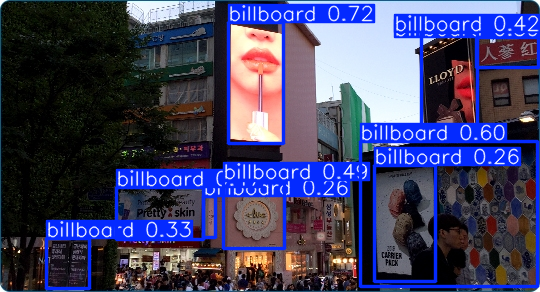

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/billboard_detect3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (18.3 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 2.0s, saved as 'runs/detect/billboard_detect3/weights/best.onnx' (36.2 MB)

Export complete (2.5s)
Results saved to /content/runs/detect/billboard_detect3/weights
Predict:         yolo predict task=detect model=runs/detect/billboard_detect3/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/billboard_detect3/weights/best.onnx imgsz=640 data=/content/Billboard-1/data.yaml  
Visualize:       https://netron.app


In [ ]:
# Load a model
model = YOLO("yolo11s.pt")

# Train the model
train_results = model.train(
    data="/content/Billboard-1/data.yaml",  # path to dataset YAML
    epochs=20,  # number of training epochs
    imgsz=640,  # training image size
    batch=8,
    workers=4,
    mosaic=0.0,
    name="billboard_detect",  # 학습 결과 폴더명
    pretrained=False,
    amp=False,
    device="cuda",
)

# Evaluate model performance on the validation set
metrics = model.val()

# Perform object detection on an image
results = model("/content/test02.jpg")
results[0].show()

### v2. 추가학습  

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/billboard_detect3/weights/last.pt, data=/content/Billboard-1/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=960, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=billboard_detect_v2, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

100%|██████████| 5.35M/5.35M [00:00<00:00, 198MB/s]


AMP: checks passed ✅


train: Scanning /content/Billboard-1/train/labels.cache... 2719 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2719/2719 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Billboard-1/valid/labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]


Plotting labels to runs/detect/billboard_detect_v2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 8 dataloader workers
Logging results to runs/detect/billboard_detect_v2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.91G      1.447      1.365      1.744         50        960: 100%|██████████| 170/170 [01:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]

                   all        510       1404      0.628      0.531      0.599      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      9.24G      1.483      1.476      1.732         49        960: 100%|██████████| 170/170 [01:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.81it/s]

                   all        510       1404      0.601      0.529      0.554      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.93G      1.511      1.548      1.762         80        960: 100%|██████████| 170/170 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]

                   all        510       1404      0.599      0.505      0.546      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      9.24G      1.491      1.535      1.735         45        960: 100%|██████████| 170/170 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

                   all        510       1404      0.609      0.481       0.52      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      9.29G      1.481      1.502      1.736         44        960: 100%|██████████| 170/170 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]

                   all        510       1404      0.613      0.518      0.582      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.91G      1.454      1.466       1.72         80        960: 100%|██████████| 170/170 [01:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

                   all        510       1404      0.642      0.539      0.602      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.93G      1.427      1.417        1.7         58        960: 100%|██████████| 170/170 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]

                   all        510       1404      0.652      0.543      0.596      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       9.3G      1.417      1.407      1.684         42        960: 100%|██████████| 170/170 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]

                   all        510       1404      0.636      0.573      0.626      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      9.25G      1.409      1.405      1.674         80        960: 100%|██████████| 170/170 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.81it/s]

                   all        510       1404      0.639      0.559       0.62      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.29G      1.399      1.358      1.671         73        960: 100%|██████████| 170/170 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]

                   all        510       1404      0.666      0.563       0.63      0.361


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.93G      1.393      1.334      1.689         63        960: 100%|██████████| 170/170 [01:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

                   all        510       1404       0.67      0.569      0.622       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      9.23G       1.38      1.294       1.68         67        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

                   all        510       1404      0.601      0.572      0.606      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.99G      1.358      1.255      1.659         46        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

                   all        510       1404      0.638      0.598      0.637      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.91G      1.342      1.221      1.652         44        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]

                   all        510       1404      0.652      0.623      0.665      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.97G      1.318      1.187      1.623         45        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

                   all        510       1404      0.669      0.607      0.666      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      9.27G       1.31      1.166      1.614         54        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]

                   all        510       1404      0.686       0.58      0.656      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.97G      1.282      1.126      1.601         33        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]

                   all        510       1404      0.677      0.613       0.68      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      9.21G      1.266      1.113      1.584         75        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

                   all        510       1404      0.673      0.636      0.696      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.26G      1.253      1.084      1.574         30        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]

                   all        510       1404      0.697      0.611      0.689      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.96G      1.229       1.06      1.563         24        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]

                   all        510       1404      0.658      0.647      0.701      0.423



20 epochs completed in 0.412 hours.
Optimizer stripped from runs/detect/billboard_detect_v2/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/billboard_detect_v2/weights/best.pt, 19.2MB

Validating runs/detect/billboard_detect_v2/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]


                   all        510       1404      0.657       0.65      0.701      0.423
Speed: 0.4ms preprocess, 6.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/billboard_detect_v2
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/Billboard-1/valid/labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


                   all        510       1404      0.657      0.653      0.701      0.424
Speed: 1.3ms preprocess, 11.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/billboard_detect_v22

image 1/1 /content/test02.jpg: 544x960 13 billboards, 80.1ms
Speed: 4.6ms preprocess, 80.1ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 960)


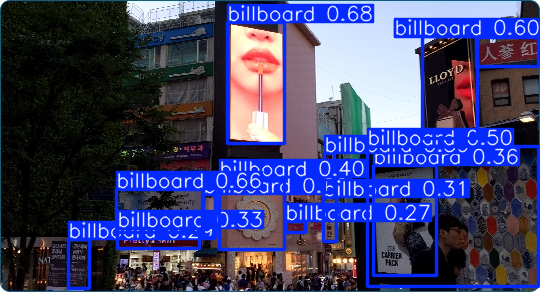

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/billboard_detect_v2/weights/best.pt' with input shape (1, 3, 960, 960) BCHW and output shape(s) (1, 5, 18900) (18.3 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 2.0s, saved as 'runs/detect/billboard_detect_v2/weights/best.onnx' (36.4 MB)

Export complete (2.7s)
Results saved to /content/runs/detect/billboard_detect_v2/weights
Predict:         yolo predict task=detect model=runs/detect/billboard_detect_v2/weights/best.onnx imgsz=960  
Validate:        yolo val task=detect model=runs/detect/billboard_detect_v2/weights/best.onnx imgsz=960 data=/content/Billboard-1/data.yaml  
Visualize:       https://netron.app


In [ ]:
# 기존 학습된 모델(last.pt)
model = YOLO("/content/runs/detect/billboard_detect3/weights/last.pt")

# 기존 학습된 모델에서 추가 학습 진행
train_results = model.train(
    data="/content/Billboard-1/data.yaml",
    epochs=20,   # 기존 학습(20) + 추가 학습(20) -> 총 40 epoch
    imgsz=960,   # 작은 객체 탐지를 위해 이미지 크기 증가
    batch=16,    # 배치 크기 증가
    mosaic=0.5,  # 데이터 증강 활성화
    name="billboard_detect_v2",  # 새 폴더에 저장 (이전과 구분)
    pretrained=False,            # last.pt를 사용하므로 False (이어 학습)
    amp=True,
    device="cuda",
)

# Evaluate model performance on the validation set
metrics = model.val()

# Perform object detection on an image
results = model("/content/test02.jpg")
results[0].show()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model

### v3. COCO 가중치를 사용하여 학습  

100%|██████████| 18.4M/18.4M [00:00<00:00, 61.9MB/s]


Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Billboard-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=960, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=billboard_detect, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 128MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 356MB/s]


AMP: checks passed ✅


train: Scanning /content/Billboard-1/train/labels... 2719 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2719/2719 [00:01<00:00, 1408.68it/s]


train: New cache created: /content/Billboard-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Billboard-1/valid/labels... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<00:00, 1227.86it/s]

val: New cache created: /content/Billboard-1/valid/labels.cache


Plotting labels to runs/detect/billboard_detect/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 4 dataloader workers
Logging results to runs/detect/billboard_detect
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.22G      1.617      3.122      1.762         42        960: 100%|██████████| 170/170 [01:08<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        510       1404      0.198      0.236      0.124     0.0464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.19G      1.782      2.125      1.945         50        960: 100%|██████████| 170/170 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all        510       1404      0.279      0.288      0.197     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.94G      1.764      2.085      1.971         79        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]

                   all        510       1404      0.308      0.296      0.239      0.091



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.17G      1.717      1.976      1.902         40        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]

                   all        510       1404      0.413      0.323      0.279      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       8.9G       1.66      1.892      1.867         59        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]

                   all        510       1404      0.482      0.425      0.418      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.15G      1.624      1.823      1.838         64        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]

                   all        510       1404      0.519      0.457      0.455      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.88G      1.564       1.73      1.784         59        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.589       0.47      0.492      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.22G      1.549      1.692      1.771         75        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]

                   all        510       1404      0.574      0.505      0.512      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.94G      1.531      1.638      1.754         66        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]

                   all        510       1404        0.6      0.491      0.536      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.22G      1.519      1.599      1.738         64        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]

                   all        510       1404      0.606      0.496      0.546      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.89G      1.493      1.576      1.717         52        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]

                   all        510       1404      0.485      0.428      0.436      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.24G      1.476      1.531      1.716         64        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.632      0.514      0.569      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.89G      1.461      1.521      1.694         68        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.618      0.546      0.586      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.87G      1.439      1.489      1.694         86        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]

                   all        510       1404        0.6       0.52      0.568      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       8.9G      1.447      1.491      1.685         52        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.631       0.54      0.598      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       9.2G      1.428      1.445      1.665         63        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]

                   all        510       1404      0.641      0.538      0.602       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       8.9G      1.419      1.446       1.66         58        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.638      0.533       0.59      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.94G      1.403      1.394      1.648         78        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.656      0.551      0.604      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.18G      1.408      1.397       1.64         68        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]

                   all        510       1404      0.641      0.538      0.596      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.21G      1.389      1.381      1.635         53        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]

                   all        510       1404      0.683      0.544      0.626      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.88G      1.378      1.347      1.632         46        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]

                   all        510       1404      0.651      0.576      0.644      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.19G      1.366      1.335      1.634         90        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]

                   all        510       1404      0.659      0.581      0.652      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.13G      1.362      1.313      1.614         66        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]

                   all        510       1404      0.621      0.574      0.612      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       9.2G      1.349      1.309      1.607         71        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.605      0.612      0.635      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.89G      1.346      1.294      1.594         56        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]

                   all        510       1404      0.684       0.59       0.66      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.96G      1.334      1.265      1.602         53        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]

                   all        510       1404      0.687      0.595      0.666      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       8.9G      1.324       1.25      1.577         69        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.622      0.604      0.636      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.87G       1.34      1.274      1.598         60        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]

                   all        510       1404      0.673       0.58      0.651      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.27G      1.304      1.226      1.573         97        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]

                   all        510       1404      0.681      0.595       0.67      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.24G      1.324      1.249      1.578         60        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.695      0.573       0.66      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.27G      1.305      1.237       1.56         51        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.695      0.573      0.671      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.18G      1.286      1.196       1.57         47        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]

                   all        510       1404       0.67      0.599      0.671      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.17G      1.294        1.2      1.548         56        960: 100%|██████████| 170/170 [01:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]

                   all        510       1404      0.676      0.607      0.675      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       8.9G       1.28       1.18      1.546         61        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]

                   all        510       1404      0.703      0.609      0.686      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.13G      1.271      1.147      1.534         77        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]

                   all        510       1404      0.676      0.601      0.681      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       8.9G      1.251      1.155      1.517         59        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]

                   all        510       1404      0.681      0.623      0.683      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.22G      1.261      1.134      1.533         39        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]

                   all        510       1404      0.667      0.619      0.673      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.88G      1.263      1.124      1.525         56        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.687      0.617      0.682      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.91G      1.227      1.094      1.509         70        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]

                   all        510       1404      0.713      0.599      0.688       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.25G      1.226      1.101      1.498         45        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404       0.66      0.635      0.685      0.415


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.21G      1.241      1.067      1.544         39        960: 100%|██████████| 170/170 [01:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]

                   all        510       1404      0.713      0.603      0.694      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.19G      1.227      1.051       1.52         63        960: 100%|██████████| 170/170 [01:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404       0.68      0.634      0.695      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.21G       1.21      1.037      1.507         28        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404      0.696      0.616      0.696      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.22G      1.206     0.9998      1.506         46        960: 100%|██████████| 170/170 [01:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]

                   all        510       1404      0.687      0.656      0.705      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.17G      1.193          1      1.502         30        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

                   all        510       1404       0.69      0.635        0.7       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.14G      1.181      0.974      1.489         69        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]

                   all        510       1404      0.689      0.658      0.711      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.17G      1.181      0.967      1.489         53        960: 100%|██████████| 170/170 [01:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]

                   all        510       1404      0.715      0.613      0.701      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.88G      1.175     0.9677      1.484         24        960: 100%|██████████| 170/170 [01:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]

                   all        510       1404      0.718      0.627      0.704      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.19G      1.162     0.9486      1.468         32        960: 100%|██████████| 170/170 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]

                   all        510       1404      0.725      0.627       0.71      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.22G      1.154     0.9287      1.464         65        960: 100%|██████████| 170/170 [01:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]

                   all        510       1404      0.706      0.649      0.708      0.436



50 epochs completed in 1.019 hours.
Optimizer stripped from runs/detect/billboard_detect/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/billboard_detect/weights/best.pt, 19.2MB

Validating runs/detect/billboard_detect/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


                   all        510       1404      0.688      0.657       0.71      0.437
Speed: 0.4ms preprocess, 6.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/billboard_detect
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/Billboard-1/valid/labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


                   all        510       1404      0.688       0.66      0.711      0.436
Speed: 1.3ms preprocess, 11.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/billboard_detect2

image 1/1 /content/test02.jpg: 544x960 15 billboards, 79.2ms
Speed: 6.1ms preprocess, 79.2ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 960)


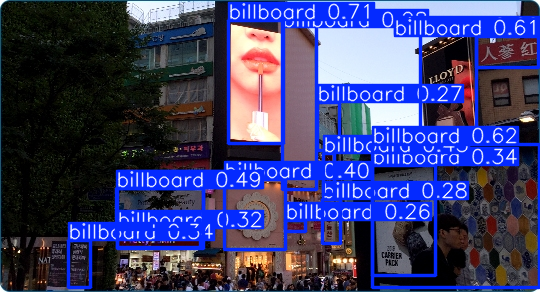

In [ ]:
# YOLOv11 모델 로드
model = YOLO("yolo11s.pt")

train_results = model.train(
    data="/content/Billboard-1/data.yaml",
    epochs=50,
    imgsz=960,   # 해상도 증가하여 작은 광고도 탐지 가능하게 조정
    batch=16,    # 배치 크기 증가
    workers=4,   # 데이터 로딩 최적화
    mosaic=0.5,  # 데이터 증강 활성화
    name="billboard_detect",
    pretrained=True,  # COCO 가중치 활용하여 빠른 수렴 유도
    amp=True,    # 자동 혼합 정밀도 활성화 (학습 속도 향상)
    device="cuda",
)

# 검증 데이터셋 성능 평가
metrics = model.val()

# 테스트 이미지에 대해 YOLOv11 객체 탐지 수행
test_image = "/content/test02.jpg"
results = model(test_image)

# 바운딩 박스 정보 추출
boxes = results[0].boxes.xyxy.cpu().numpy()        # (x1, y1, x2, y2)
confidences = results[0].boxes.conf.cpu().numpy()  # 신뢰도

results[0].show()

### v4. 백본 동결 후 파인튜닝  

In [ ]:
# Load a model
model = YOLO("yolo11s.pt")

print(model.model) # yolo11 모델 구조 확인

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
 

In [ ]:
model = YOLO("yolo11s.pt")

# Backbone 찾기 -> 초반 레이어 (Conv, C3) 동결
for layer in list(model.model.children())[:9]:  # 앞 9개 레이어 동결
    for param in layer.parameters():
        param.requires_grad = False

results = model.train(
    data="/content/Billboard-1/data.yaml",
    epochs=20,  # YOLO 헤드만 학습
    imgsz=640,
    batch=16,
    freeze=9    # 백본 0~8번 레이어 동결
)

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Billboard-1/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=9, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 125MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 275MB/s]


AMP: checks passed ✅


train: Scanning /content/Billboard-1/train/labels... 2719 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2719/2719 [00:01<00:00, 1413.07it/s]


train: New cache created: /content/Billboard-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Billboard-1/valid/labels... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<00:00, 1708.06it/s]


val: New cache created: /content/Billboard-1/valid/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.25G      1.473       2.12      1.501         93        640: 100%|██████████| 170/170 [00:32<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]

                   all        510       1404      0.494      0.436      0.381      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.36G      1.558      1.635      1.589         76        640: 100%|██████████| 170/170 [00:31<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

                   all        510       1404      0.469      0.485      0.415      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.23G      1.552      1.606      1.592        113        640: 100%|██████████| 170/170 [00:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]

                   all        510       1404      0.603      0.529      0.548      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.23G       1.51      1.527      1.542         71        640: 100%|██████████| 170/170 [00:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404      0.648      0.556      0.587      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.38G      1.476      1.459      1.535         75        640: 100%|██████████| 170/170 [00:30<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        510       1404      0.654      0.538      0.586      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.4G      1.447      1.416      1.509         75        640: 100%|██████████| 170/170 [00:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]

                   all        510       1404      0.608      0.558      0.585      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.23G      1.406      1.362      1.479         47        640: 100%|██████████| 170/170 [00:30<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404      0.691      0.564      0.649      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.35G      1.385      1.345      1.482         82        640: 100%|██████████| 170/170 [00:30<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404      0.715      0.547      0.644      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.24G      1.366      1.314      1.457         79        640: 100%|██████████| 170/170 [00:30<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404       0.64      0.569      0.614      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.32G      1.352      1.306      1.446         77        640: 100%|██████████| 170/170 [00:30<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]

                   all        510       1404      0.646      0.585      0.647       0.38


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.22G      1.405      1.323      1.527         63        640: 100%|██████████| 170/170 [00:31<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        510       1404      0.678      0.578      0.655      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.36G      1.388      1.279      1.506         67        640: 100%|██████████| 170/170 [00:30<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]

                   all        510       1404      0.599      0.566      0.592      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.37G      1.372      1.261      1.498         46        640: 100%|██████████| 170/170 [00:30<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        510       1404       0.67       0.61      0.666      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.22G      1.351      1.207      1.484         44        640: 100%|██████████| 170/170 [00:30<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

                   all        510       1404      0.671      0.611      0.659      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.38G      1.332       1.19      1.476         45        640: 100%|██████████| 170/170 [00:30<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]

                   all        510       1404      0.695      0.596      0.671      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.32G      1.307      1.148      1.449         54        640: 100%|██████████| 170/170 [00:30<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404      0.696      0.595      0.668      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.24G      1.292      1.117      1.436         33        640: 100%|██████████| 170/170 [00:30<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        510       1404      0.696      0.619      0.696       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.28G      1.276      1.103      1.428         75        640: 100%|██████████| 170/170 [00:30<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        510       1404      0.692      0.627       0.69      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.36G      1.262      1.065      1.406         30        640: 100%|██████████| 170/170 [00:30<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]

                   all        510       1404      0.696      0.626      0.689      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.35G      1.238      1.039      1.403         24        640: 100%|██████████| 170/170 [00:30<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        510       1404      0.718      0.614      0.703       0.43



20 epochs completed in 0.202 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 19.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


                   all        510       1404      0.718      0.616      0.703       0.43
Speed: 0.2ms preprocess, 4.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
# 1단계 학습한 best.pt 모델 로드
model = YOLO("/content/runs/detect/train2/weights/best.pt")

# Backbone 가중치 해제
for layer in list(model.model.children())[:9]:
    for param in layer.parameters():
        param.requires_grad = True

# Fine-Tuning-백본 포함 전체 학습
results = model.train(
    data="/content/Billboard-1/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.0001,
    patience=10,
    seed=1234  # 재현성을 위해 seed 설정
)

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train2/weights/best.pt, data=/content/Billboard-1/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1234, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

train: Scanning /content/Billboard-1/train/labels.cache... 2719 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2719/2719 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Billboard-1/valid/labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.21G      1.351      1.299      1.438         93        640: 100%|██████████| 170/170 [00:48<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]

                   all        510       1404      0.538       0.51      0.502      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.08G      1.464      1.548      1.532         76        640: 100%|██████████| 170/170 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]

                   all        510       1404      0.539      0.487      0.485       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.09G      1.532      1.646      1.576        113        640: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]

                   all        510       1404      0.543      0.488      0.472      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.08G      1.513      1.632      1.559         71        640: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]

                   all        510       1404      0.525      0.457      0.464      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.24G      1.513      1.593      1.566         75        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]

                   all        510       1404      0.627      0.477      0.529      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       4.1G      1.489      1.549      1.535         75        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]

                   all        510       1404      0.604      0.495      0.542      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.07G      1.434      1.482      1.512         47        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        510       1404      0.608      0.548       0.58      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.21G      1.432      1.513       1.53         82        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510       1404       0.64      0.516      0.581      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       4.1G      1.411       1.45      1.493         79        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]

                   all        510       1404      0.599      0.514       0.55      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.22G      1.391      1.441       1.48         77        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]

                   all        510       1404      0.619      0.517      0.562      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.96G      1.406       1.42      1.485         60        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        510       1404      0.604      0.536      0.574      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.07G      1.377      1.398      1.472         57        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510       1404      0.663      0.518      0.601      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       4.1G       1.36      1.363      1.454         77        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]

                   all        510       1404       0.63      0.559      0.608      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.23G      1.359      1.373       1.45        103        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404      0.605      0.546      0.595      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.08G      1.367       1.34      1.448         58        640: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510       1404      0.685      0.555      0.627      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.09G      1.331      1.308      1.434         68        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        510       1404      0.656      0.544      0.626      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.11G      1.332      1.299      1.442         71        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510       1404      0.661      0.585      0.651      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.24G      1.332      1.315      1.436         83        640: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        510       1404      0.679      0.583      0.651      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.25G      1.317       1.28      1.422        107        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510       1404      0.664      0.571      0.635      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.09G      1.311      1.263      1.421        102        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404      0.679      0.597      0.665      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.27G      1.303       1.24      1.413         59        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        510       1404      0.687      0.596      0.662      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.06G      1.301      1.261      1.415         73        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]

                   all        510       1404      0.669      0.603      0.655      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.19G      1.296      1.219      1.402         86        640: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]

                   all        510       1404      0.691      0.573       0.66        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.06G        1.3      1.226        1.4         55        640: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]

                   all        510       1404      0.669      0.592      0.663      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.07G      1.289      1.212      1.395         76        640: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        510       1404      0.678        0.6      0.666      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.09G      1.274      1.206      1.393         65        640: 100%|██████████| 170/170 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]

                   all        510       1404      0.692      0.593      0.666      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.07G      1.271      1.192      1.388         68        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]

                   all        510       1404      0.697      0.598      0.678      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.23G      1.255      1.163      1.388         63        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        510       1404        0.7      0.603      0.681       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.24G      1.247      1.158      1.377         62        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]

                   all        510       1404       0.69      0.597      0.675      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.09G      1.246      1.156      1.372         82        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]

                   all        510       1404      0.675      0.584       0.67      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       4.1G      1.242      1.139       1.37         75        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404      0.716      0.599      0.694      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.06G      1.237      1.123      1.369         62        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404      0.708      0.602      0.691      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       4.1G      1.229      1.126      1.355        112        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

                   all        510       1404      0.709      0.608      0.683      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.09G      1.227      1.102      1.356         80        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]

                   all        510       1404      0.678      0.634      0.687      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.07G      1.207      1.094       1.34         96        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

                   all        510       1404      0.706      0.638      0.703      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.06G      1.217        1.1      1.357         55        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

                   all        510       1404       0.68      0.653      0.697      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.08G      1.194      1.068      1.337         55        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]

                   all        510       1404      0.686      0.615      0.672      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.21G       1.19      1.061      1.333         78        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]

                   all        510       1404      0.721      0.618      0.703       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.06G      1.187      1.057      1.333         84        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510       1404       0.73      0.615      0.702      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.19G      1.203      1.067      1.348         70        640: 100%|██████████| 170/170 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]

                   all        510       1404      0.693      0.633      0.699       0.43


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.06G      1.205      1.041      1.382         37        640: 100%|██████████| 170/170 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

                   all        510       1404      0.705      0.642      0.705      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.04G      1.202      1.004      1.377         65        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]

                   all        510       1404      0.712      0.629      0.701      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       4.2G      1.186     0.9934      1.371         27        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]

                   all        510       1404      0.711      0.646      0.707      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.24G      1.175     0.9734      1.348         40        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

                   all        510       1404      0.703      0.642      0.704      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.19G      1.165     0.9546      1.352         32        640: 100%|██████████| 170/170 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

                   all        510       1404      0.727      0.619      0.705      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.19G       1.16     0.9514      1.342         72        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

                   all        510       1404      0.734      0.625      0.707      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.17G      1.157     0.9503      1.343         56        640: 100%|██████████| 170/170 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510       1404       0.74      0.622      0.708      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.06G      1.146     0.9262      1.328         24        640: 100%|██████████| 170/170 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]

                   all        510       1404      0.732       0.63      0.706      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       4.1G       1.13     0.9194      1.323         34        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]

                   all        510       1404      0.718      0.637      0.706      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.07G      1.128      0.907      1.332         60        640: 100%|██████████| 170/170 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]

                   all        510       1404      0.731      0.625      0.706      0.442



50 epochs completed in 0.712 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 19.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]


                   all        510       1404      0.729      0.628      0.706      0.442
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train3


In [ ]:
# 성능평가
model = YOLO("runs/detect/train3/weights/best.pt")
metrics = model.val()

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/Billboard-1/valid/labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


                   all        510       1404      0.729       0.63      0.706      0.442
Speed: 0.6ms preprocess, 9.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val



image 1/1 /content/test06.jpg: 448x640 7 billboards, 52.0ms
Speed: 2.3ms preprocess, 52.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


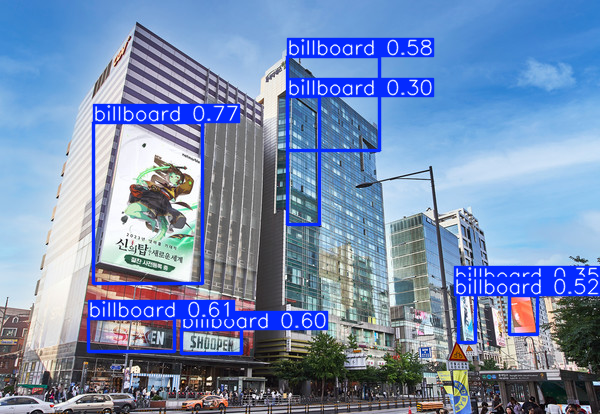

In [ ]:
# 테스트
results = model("/content/test06.jpg")
results[0].show()

#### 모델 저장
- 신뢰도가 높은 객체만 표시  


image 1/1 /content/test06.jpg: 448x640 7 billboards, 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


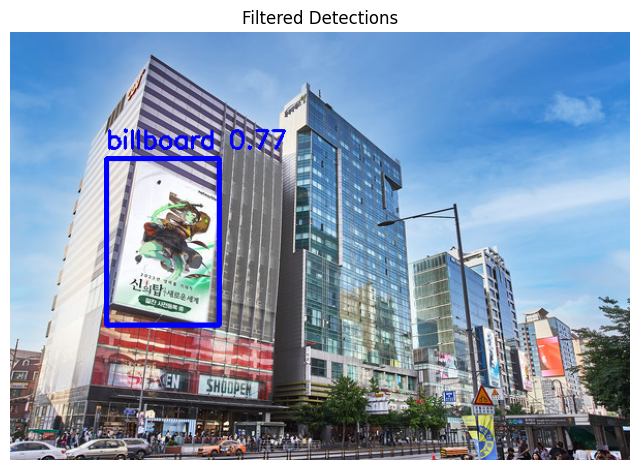

In [ ]:
model = YOLO("/content/best-0228.pt")

image_path = "/content/test06.jpg"

# 객체 탐지 수행 신뢰도가 가장 높은 객체 선택
results = model(image_path)
detections = results[0]

if len(detections.boxes) > 0:
    best_box = max(detections.boxes, key=lambda box: box.conf.item())

    # Bounding Box 좌표 및 클래스 정보
    x1, y1, x2, y2 = map(int, best_box.xyxy[0].tolist())
    conf = best_box.conf.item()
    class_id = int(best_box.cls.item())
    class_name = results[0].names[class_id]

    # 가장 큰 객체 Bounding Box 표시
    img = cv2.imread(image_path)
    color = (255, 0, 0)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
    label = f"{class_name} {conf:.2f}"
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Filtered Detections")
plt.axis("off")
plt.show()

In [ ]:
# yolo11s best model download
!gdown 1A6_iThtWBlzgvGqOP9QXuDYGFL809jYL

Downloading...
From: https://drive.google.com/uc?id=1A6_iThtWBlzgvGqOP9QXuDYGFL809jYL
To: /content/best-0228.pt
100% 19.2M/19.2M [00:00<00:00, 39.4MB/s]



image 1/1 /content/test02.jpg: 352x640 9 billboards, 53.4ms
Speed: 6.8ms preprocess, 53.4ms inference, 354.9ms postprocess per image at shape (1, 3, 352, 640)


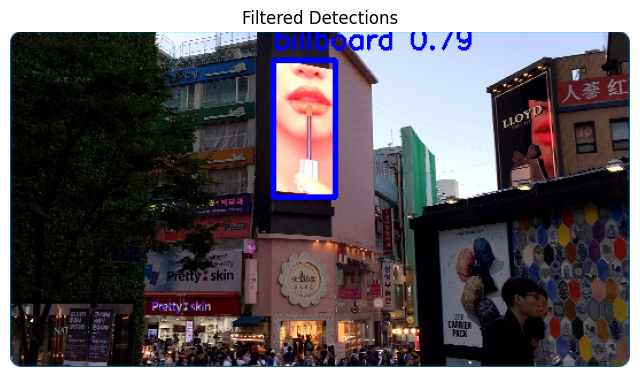

In [ ]:
# 기존 학습된 모델 로드
model = YOLO("/content/best-0228.pt")

# 테스트 이미지 경로
image_path = "/content/test02.jpg"

results = model(image_path) # 객체 탐지 수행
detections = results[0]     # 첫 번째 이미지에 대한 결과

# 신뢰도가 가장 높은 객체 찾기
if len(detections.boxes) > 0:
    # 신뢰도(Confidence score)가 가장 높은 객체 찾기
    best_box = max(detections.boxes, key=lambda box: box.conf.item())

    # Bounding Box 좌표 및 클래스 정보 가져오기
    x1, y1, x2, y2 = map(int, best_box.xyxy[0].tolist())  # 경계 상자 좌표
    conf = best_box.conf.item()  # 신뢰도
    class_id = int(best_box.cls.item())
    class_name = results[0].names[class_id]

    img = cv2.imread(image_path)

    # 경계 상자 그리기
    color = (255, 0, 0)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)

    # 텍스트 정보 추가
    label = f"{class_name} {conf:.2f}"
    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Filtered Detections")
plt.axis("off")
plt.show()